# Ensemble Methods
Ensemble methods are *meta-algorithms* that add randomization to learning algorithms so to have them generate multiple predictors on the same training data. These predictors are then aggregated, either linearly or by taking a majority vote, to form a single predictor.

Adding randomization and then combining predictors has an *averaging effect* on the performance of the learning algorithm, which corresponds to **reducing variance** and **increasing bias**.

For this reason, ensemble methods are often used with nonparametric learning algorithms (such as tree predictors) that have little bias.

In this notebook we explore two such methods: bagging and random forests.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, learning_curve

%matplotlib inline

/home/nicolo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Forest Cover Type Dataset
This dataset includes information on tree type (the labels to predict), shadow coverage, distance to nearby landmarks (e.g., roads), soil type, and local topography. There are 7 classes denoting tree types, 55 features, and a total of 15120 data points.

In [2]:
forest = pd.read_csv('../Datasets/forest-cover-type.csv')
forest.shape

(15120, 56)

In [3]:
forest.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


The class distribution is perfectly balanced.

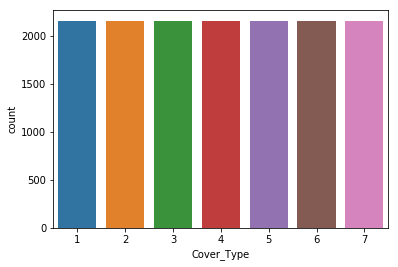

In [4]:
ax = sns.countplot(x="Cover_Type", data=forest)

We control that there are no missing values with the method `isna()`, and then we sum the results over rows in each column.

In [5]:
forest.isna().sum() # check for missing values in columns

Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


We then create two `ndarrays` $X$ and $y$ containing data points and labels. We also create a train-test split with proportions $2/3-1/3$.

In [6]:
X = forest.drop(columns=['Id', 'Cover_Type']).values
y = forest['Cover_Type'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Next, we evaluate a tree classifier algorithm on this split.

In [7]:
tree_lrn = DecisionTreeClassifier()

tree_lrn.fit(X_train, y_train)
y_pred = tree_lrn.predict(X_test)
test_score = accuracy_score(y_test,y_pred)
np.round(test_score, decimals=2)

0.77

The resulting tree classifier is quite large and deep.

In [8]:
int(tree_lrn.tree_.node_count), int(tree_lrn.tree_.max_depth)

(3085, 30)

Now we look at the learning curve from 1K to 9K examples.

In [9]:
sizes = range(1000, 10001, 2000)
train_size, train_score, val_score = learning_curve(tree_lrn, X, y, train_sizes=sizes, cv=3)

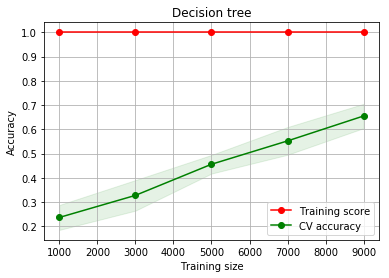

In [10]:
plt.title('Decision tree')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

Zero training error indicates that the algorithm has no bias, while the large difference between training and test performance reveals a high variance. The final cross-validated performance is only $65\%$.

In [11]:
list(np.round(np.mean(val_score, 1), decimals=2))

[0.24, 0.33, 0.46, 0.55, 0.66]

## Bagging
The first ensemble method we explore on this dataset is *Bagging*. This method uses any base algorithm $A$ and creates different predictors on a given training set $S$ (viewed as a $m \times d$ matrix of data points and features) by subsampling rows and colums of $S$ and feeding the resulting random matrix to $A$.

We run bagging with the tree classifier algorithm as base algorithm.

We start by looking at the learning curve while using bagging over a **single** tree classifier.

In [12]:
bag_lrn = BaggingClassifier(base_estimator=tree_lrn, n_estimators=1)
sizes = range(1000, 10001, 2000)
train_size, train_score, val_score = learning_curve(bag_lrn, X, y, train_sizes=sizes, cv=3)

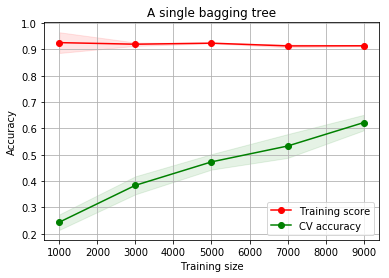

In [13]:
plt.title('A single bagging tree')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

Due to the subsampling of the data matrix, the bagged algorithm has a higher bias and a smaller variance than the base algorithm. However the cross-validated accuracy went down a bit, revealing that the decrease in variance did not compensate for the increase in bias.

In [14]:
list(np.round(np.mean(val_score, 1), decimals=2))

[0.24, 0.38, 0.47, 0.53, 0.62]

We now test bagging with $10$ tree classifiers instead of one.

In [15]:
tree_lrn = DecisionTreeClassifier()
bag_lrn = BaggingClassifier(base_estimator=tree_lrn, n_estimators=10)
sizes = range(1000, 10001, 2000)
train_size, train_score, val_score = learning_curve(bag_lrn, X, y, train_sizes=sizes, cv=3)

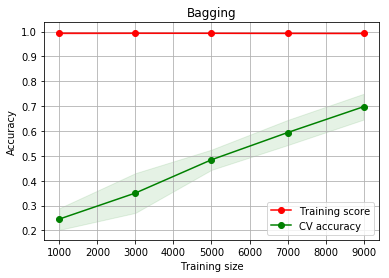

In [16]:
plt.title('Bagging')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

Note that the resulting bagged algorithm has now essentially no bias on this dataset (zero training error), and the variance has improved with respect to using a single tree classifier.

In [17]:
list(np.round(np.mean(val_score, 1), decimals=2))

[0.25, 0.35, 0.48, 0.59, 0.7]

## Random Forest
Our second method is *Random Forest*. Unlike bagging, Random Forest uses **only tree predictor algorithms as base algorithms**. The data matrix is subsampled as in Bagging, but Random Forest uses an additional randomization. When splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features (as in the standard tree classifier algorithm). Instead, the split is optimized over a random subset of the features. Hence the bias of Random Forest is higher than that of Bagging applied to tree predictors, but the decrease in variance usually compensates for the increase in bias, hence yielding an overall better model.

As Random Forest works well also with shallow trees, we limit the depth of the trees to $10$.

In [18]:
rf_lrn = RandomForestClassifier(n_estimators=10, max_depth=10)
sizes = range(1000, 10001, 2000)
train_size, train_score, val_score = learning_curve(rf_lrn, X, y, train_sizes=sizes, cv=3)

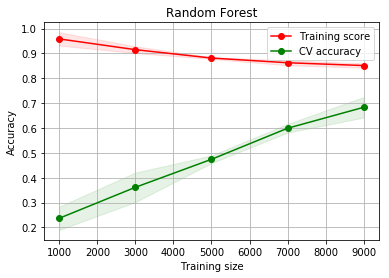

In [19]:
plt.title('Random Forest')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

As expected, the bias increased and the decrease of the variance compensated this increase. However, the resulting performance is similar if not worse than that of Bagging.

In [20]:
list(np.round(np.mean(val_score, 1), decimals=2))

[0.24, 0.36, 0.47, 0.6, 0.68]

We now investigate how the depth of the trees affects the performance of Random Forest. We explore a range of depths from $3$ to $30$.

In [21]:
depths = np.arange(3,31,3)
learner = RandomForestClassifier(n_estimators=10)
train_score, val_score = validation_curve(learner, X, y, 'max_depth', depths, cv=3)

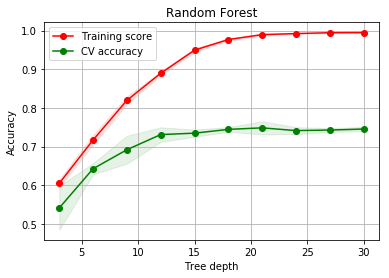

In [22]:
plt.title('Random Forest')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(depths, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(depths, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(depths, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(depths, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.show()

Note that depths larger than $15$ give little or no improvement. Therefore, we run a direct comparison between Bagging and Random Forest with tree depth capped at $15$. We plot cross-validated performance for $1$, $10$ and $100$ trees.

In [23]:
num_trees = [1,10,100]
tree_lrn = DecisionTreeClassifier()
bag_lrn = BaggingClassifier(base_estimator=tree_lrn)
rf_lrn = RandomForestClassifier(max_depth=15)
train_score, bag_val_score = validation_curve(bag_lrn, X, y, 'n_estimators', num_trees, cv=3)
train_score, rf_val_score = validation_curve(rf_lrn, X, y, 'n_estimators', num_trees, cv=3)

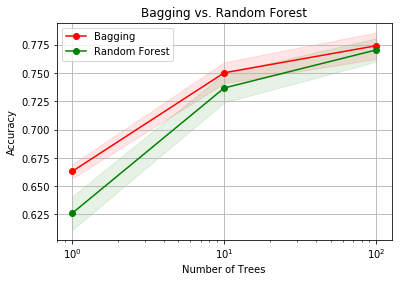

In [24]:
plt.title('Bagging vs. Random Forest')
bag_val_score_mean = np.mean(bag_val_score, axis=1)
bag_val_score_std = np.std(bag_val_score, axis=1)
rf_val_score_mean = np.mean(rf_val_score, axis=1)
rf_val_score_std = np.std(rf_val_score, axis=1)
plt.grid()
plt.xscale("log")
plt.fill_between(num_trees, bag_val_score_mean - bag_val_score_std,
                 bag_val_score_mean + bag_val_score_std, alpha=0.1,
                 color="r")
plt.fill_between(num_trees, rf_val_score_mean - rf_val_score_std,
                 rf_val_score_mean + rf_val_score_std, alpha=0.1, color="g")
plt.plot(num_trees, bag_val_score_mean, 'o-', color="r",
         label="Bagging")
plt.plot(num_trees, rf_val_score_mean, 'o-', color="g",
         label="Random Forest")
plt.legend()
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.show()

In this case, Bagging still performs better but Random Forest uses trees that are much smaller on average than those used by Bagging (depth $15$ as opposed to depth around $30$).

Next, we consider a different dataset.

### MNIST dataset
Handwritten numerals. The original dataset is already split in training (60K) and test (10K) sets. For efficiency reasons, we only work with the test set, which we further split in training and test.

Each row of the data matrix consists of 785 values: the first value is the label (a number from 0 to 9) and the remaining 784 values are the pixel values (a number from 0 to 255).

In [25]:
mnist = pd.read_csv("../Datasets/MNIST/mnist_test.csv")
mnist.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
mnist.shape

(10000, 785)

We create the data matrix, the list of labels, and a train/test split with proportions $4/5-1/5$.

In [27]:
mnist_X = mnist.drop("label",1)
mnist_y = mnist["label"]
X = mnist_X.values
y = mnist_y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In this case, it is instructive to visualize the original images from the list of pixels.

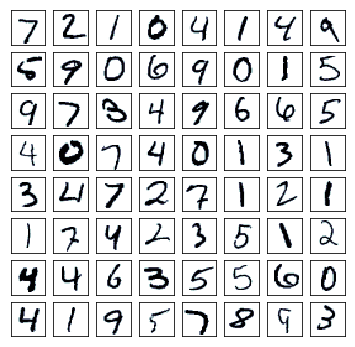

In [28]:
plt.figure(figsize=(6,6))
for digit_num in range(0,64):
    plt.subplot(8,8,digit_num+1)
    grid_data = mnist_X.iloc[digit_num].values.reshape(28,28)
    plt.imshow(grid_data, interpolation = "none", cmap = "bone_r")
    plt.xticks([])
    plt.yticks([])

We start by checking the performance of the standard tree classifier algorithm. Since the number of features is higher in this dataset, we set the option `random` for choosing which leaf to split. This speeds up the computation at the cost of building a slightly larger tree.

In [29]:
tree_lrn = DecisionTreeClassifier(splitter='random')

tree_lrn.fit(X_train, y_train)
y_pred = tree_lrn.predict(X_test)
test_score = accuracy_score(y_test,y_pred)
np.round(test_score, decimals=2)

0.8

In [30]:
int(tree_lrn.tree_.node_count), int(tree_lrn.tree_.max_depth)

(1971, 23)

The analysis of the learning curve for the tree classifier algorithm shows essentially no bias and a large variance (see below). Another good case for Bagging!

In [31]:
sizes = range(1000, 6666, 1000)
train_size, train_score, val_score = learning_curve(tree_lrn, X, y, train_sizes=sizes, cv=3)

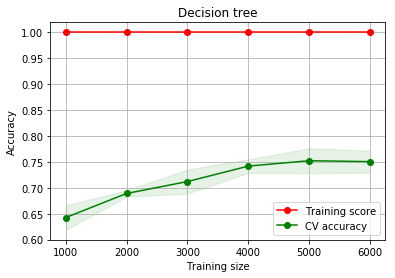

In [32]:
plt.title('Decision tree')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

We run the tree classifier algorithm as base algorithm for Bagging, and we generate a total of $10$ trees.

In [33]:
tree_lrn = DecisionTreeClassifier(splitter='random')
bag_lrn = BaggingClassifier(base_estimator=tree_lrn, n_estimators=10)
sizes = range(1000, 6666, 1000)
train_size, train_score, val_score = learning_curve(bag_lrn, X, y, train_sizes=sizes, cv=3)

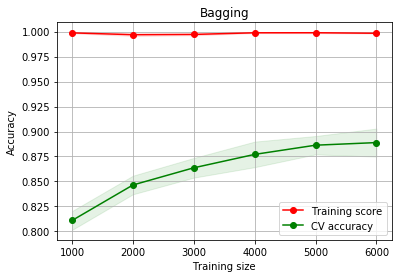

In [34]:
plt.title('Bagging')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

Bagging is working pretty well: we did not get any bias and the variance went down significantly.

We now check the performance of Random Forest with a cap of $10$ on the depth of the trees.

In [35]:
rf_lrn = RandomForestClassifier(n_estimators=10, max_depth=10)

sizes = range(1000, 6666, 1000)
train_size, train_score, val_score = learning_curve(rf_lrn, X, y, train_sizes=sizes, cv=3)

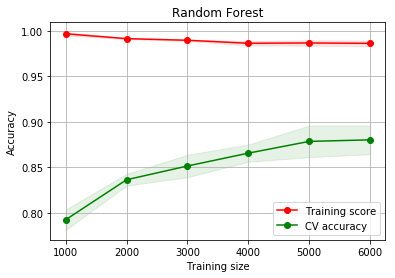

In [36]:
plt.title('Random Forest')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(train_size, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(train_size, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(train_size, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_size, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.show()

OK, while the variance error went down nicely, the overall performance is worse than Bagging due to a slight increase of the bias.

We then take a look at the performance of Random Forest as we vary the depth of the trees.

In [37]:
depths = np.arange(3,31,3)
learner = RandomForestClassifier(n_estimators=10)
train_score, val_score = validation_curve(learner, X, y, 'max_depth', depths, cv=3)

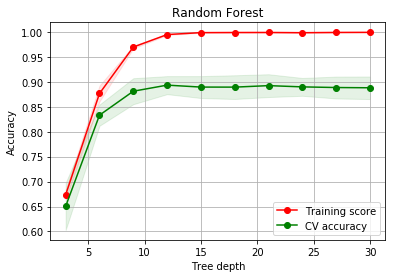

In [38]:
plt.title('Random Forest')
train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)
val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)
plt.grid()
plt.fill_between(depths, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.1,
                 color="r")
plt.fill_between(depths, val_score_mean - val_score_std,
                 val_score_mean + val_score_std, alpha=0.1, color="g")
plt.plot(depths, train_score_mean, 'o-', color="r",
         label="Training score")
plt.plot(depths, val_score_mean, 'o-', color="g",
         label="CV accuracy")
plt.legend()
plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.show()

We see a good spot at approximately depth $12$. We are now ready to run a direct comparison between Bagging and Random Forest with depth capped at $12$. In order to further speed up computation, we use two other options: `min_samples_split=20` (the minimum number of examples required to split a leaf) and `min_samples_leaf=10` (a split will only be considered if it leaves at least $10$ training examples in each child leaf).

In [39]:
num_trees = [1,10,100]
tree_lrn = DecisionTreeClassifier(splitter='random', min_samples_split=20, min_samples_leaf=10)
bag_lrn = BaggingClassifier(base_estimator=tree_lrn)
rf_lrn = RandomForestClassifier(max_depth=12, min_samples_split=20, min_samples_leaf=10)
train_score, bag_val_score = validation_curve(bag_lrn, X, y, 'n_estimators', num_trees, cv=3)
train_score, rf_val_score = validation_curve(rf_lrn, X, y, 'n_estimators', num_trees, cv=3)

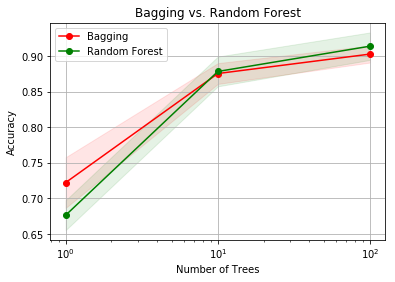

In [40]:
plt.title('Bagging vs. Random Forest')
bag_val_score_mean = np.mean(bag_val_score, axis=1)
bag_val_score_std = np.std(bag_val_score, axis=1)
rf_val_score_mean = np.mean(rf_val_score, axis=1)
rf_val_score_std = np.std(rf_val_score, axis=1)
plt.grid()
plt.xscale("log")
plt.fill_between(num_trees, bag_val_score_mean - bag_val_score_std,
                 bag_val_score_mean + bag_val_score_std, alpha=0.1,
                 color="r")
plt.fill_between(num_trees, rf_val_score_mean - rf_val_score_std,
                 rf_val_score_mean + rf_val_score_std, alpha=0.1, color="g")
plt.plot(num_trees, bag_val_score_mean, 'o-', color="r",
         label="Bagging")
plt.plot(num_trees, rf_val_score_mean, 'o-', color="g",
         label="Random Forest")
plt.legend()
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.show()

So, finally Random Forest is taking the lead when the number of trees is large enough. Recall that Random Forest predictors have a much smaller memory footprint than Bagging predictors. For this reason, Random Forest is often preferred in industrial applications. Both methods are highly parallelizable, as trees can be spread across many cores and evaluated in parallel.